### Introduction

During Run2, the CERN Accelerator Complex data were stored in the CERN Accelerator Logging Database (CALS) provided by CO. 
CALS provided a crucial input for monitoring, understanding and optimizing the machines.

Since few years CO is preparing a new database (NXCALS) than will more suitable to store the ever increasing demand of storage capability.
For CALS we massively use the **pytimber** (R. De Maria) package and **pandas** DF to extract and postprocess the data.

A new version of **pytimber** (R. De Maria and the NXCALS team) has been released: most of the interfaces used for CALS are now available also NXCALS.
The aim is to have the best-possible back-compatibility from the user point of view between CALS and NXCALS. 
 

In this ipnb we will present few examples on how to use **pyspark** methods to access NXCALS (therefore we will not consider **pytimber** in most of the cases). **pyspark** opens the possibility to make big data analysis.
For most of the use case (at least at moment), big data analysis is NOT needed, but NXCALS is naturally oriented to it and **pyspark** is already available from the python/SPARK community. 

With **pyspark** one can postprocess (e.g., aggregate, filter, transform) the data on the cluster before retrieving them.

In this ipynb we present few examples.

We are still using **pytimber** to search for the variable names. Indeed there is not a pure pythonic way to extract them: so we are using available java libraries via **pytimber**. 

The final aim of this ipynb is to collect some thoughts and share it with our community to optimize (and merge in future?) the different approaches.

We are not SPARK experts but we think that ipynb can bootstrap the discussion.

!!! info
    The full ipynb is available in the gitlab repository of this website.

### Some elements about the setup

We use the following stack from SWAN 

In [1]:
!which python

/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3_nxcals/x86_64-centos7-gcc7-opt/bin/python


We are using the following configuration 

| Parameter | Setting |
|-----------|---------|
|    spark.executor.instances    |  20 |
|    spark.driver.cores          |  8  |
|    spark.executor.cores        | 4   |
|    spark.driver.memory         | 12 GB  |

Note that the driver RAM memory is 12 GB. A typical query can run on a less resources. 
Probably the configuration can be optimized for improving resource sharing. 
This will require interaction with the NXCALS team.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# You need a very simple package (on the gitlab of this web site)
# We will put on github if needed.
# Most of the ipynb can be run w/o this package
from nx2pd import nx2pd as nx 
nx.spark=spark

### First steps

We can retrieve the list of variables with this simple method (it is just calling **pytimber** behind the scene)

In [4]:
nx.searchVariables(['PR%MTE%','HX:F%N','PSB.LSA%','%P%.TGM:B%D','PR-SIMA-1:CURRENT_%V'])

['CPS.TGM:BEAMID',
 'HX:FILLN',
 'PR-SIMA-1:CURRENT_18V',
 'PR-SIMA-1:CURRENT_5V',
 'PR.SCOPE48.CH01:MTE_EFFICIENCY',
 'PR.SCOPE48.CH01:MTE_SPILL',
 'PSB.LSA:CYCLE',
 'PSB.TGM:BEAMID',
 'SPS.TGM:BEAMID']

It is important to note that the name of the variables can have also special characters (like '.', ':' and '-'). 

We strongly suggest to use tz-aware timestamp (possibly in UTC, UTC representation is continuous and monotonic while CET is not).

!!! info
    NXCALS timestamp are UTC based. 

In [5]:
pd.Timestamp('2018-10-28 2:15', tz='UTC')
# pd.Timestamp('2018-10-28 2:15', tz='CET') this timestamp dows not exist, therefore you get an error

Timestamp('2018-10-28 02:15:00+0000', tz='UTC')

In the following we are going to consider two possible ways to extract data from NXCALS.
 

### Using directly pandas DF

One could directly recover the pandas DF (dataframe). This can be used for small datas (less than the RAM of the driver) and it is quite convenient 
(probably is covering more than 99% of the needs).
It is very similar to **pytimber** approach but instead of dictionaries one get directly pandas DF.

In [6]:
t1='2018-09-01'        # it will be converted automatic in 'UTC'
t2='2018-09-01 00:01'  # it will be converted automatic in 'UTC'
fromNXCALS=nx.nx2pd(nx.searchVariables(['CPS.LSA:CYCLE', 'CPS.TGM:USER']), t1, t2)
fromNXCALS.head()

CPS.LSA:CYCLE CPS.TGM:USER
2018-09-01 00:00:01.900000+00:00           TOF          TOF
2018-09-01 00:00:03.100000+00:00           TOF          TOF
2018-09-01 00:00:04.300000+00:00    EAST_IRRAD        EAST1
2018-09-01 00:00:06.700000+00:00     MTE_2018_      SFTPRO1
2018-09-01 00:00:07.900000+00:00     MTE_2018_      SFTPRO1

### Using pyspark DF
For large data we cannot recover the pandas DF on the driver (RAM limits of the driver, where all pandas DF are collected). Hence we need to aggregate/reduce the data size in the spark executors and retrieve the output, once can be allocated on the driver. To do that one needs to learn **pyspark**. We think that learning by the few following examples from "our world" will speed up the learning curve (clearly there is a large community on **pyspark**). 

From what we understood, the naming convention of the pyspark impose (to be compatible with the pyspark syntax) not to have '.', ':' and '-' in the name of the columns. This is not compatible with the CALS variables naming (e.g.,'PR.SCOPE48.CH01:MTE_EFFICIENCY').

As fix to this problem, we are replacing '.', ':' and '-' with two, three or four underscores, respectively.

!!! warning
    This replacing is going to be annoying...
    
!!! todo
    Ask suggestions to NXCALS team.

In [8]:
import io
import time
from cern.nxcals.api.extraction.data.builders import *
import pyspark.sql.functions as func
from pyspark.sql.functions import col
from pyspark.sql.types import *
import numpy as np

def _replace_specials(myString):
    return myString.replace(':','___').replace('.','__').replace('-','____')

def _invert_replace_specials(myString):
    return myString.replace('___',':').replace('__','.').replace('____','-') # clearly the operation is invertible only under some hypothesis

def _importNXCALS(variableName,t1, t2):
    ''' This hidden function takes a string a two pd datastamps. NXCALSsample is the fraction of rows to return.'''
    start_time = time.time()
    t1=t1.tz_convert('UTC').tz_localize(None)
    t2=t2.tz_convert('UTC').tz_localize(None)
    ds=DataQuery.builder(spark).byVariables().system("CMW")\
    .startTime(t1.strftime('%Y-%m-%d %H:%M:%S.%f')).endTime(t2.strftime('%Y-%m-%d %H:%M:%S.%f')).variable(variableName).buildDataset()
    selectionStringDict={'int':{'value':'nxcals_value','label':'nxcals_value'}, 'double':{'value':'nxcals_value','label':'nxcals_value'},
                        'float':{'value':'nxcals_value','label':'nxcals_value'}, 'string':{'value':'nxcals_value','label':'nxcals_value'},
                        'bigint':{'value':'nxcals_value','label':'nxcals_value'},
                        'struct<elements:array<int>,dimensions:array<int>>':{'value':'nxcals_value.elements','label':'elements'},
                        'struct<elements:array<double>,dimensions:array<int>>':{'value':'nxcals_value.elements','label':'elements'},
                        'struct<elements:array<float>,dimensions:array<int>>':{'value':'nxcals_value.elements','label':'elements'},}
    selectionStringValue=selectionStringDict[dict(ds.dtypes)['nxcals_value']]['value']
    selectionStringLabel=selectionStringDict[dict(ds.dtypes)['nxcals_value']]['label']
    aux=ds.select('nxcals_timestamp',selectionStringValue)
    return aux.withColumnRenamed('nxcals_timestamp','timestamp').withColumnRenamed(selectionStringLabel,_replace_specials(variableName))

t1=pd.Timestamp('2018-10-01', tz='UTC')
t2=pd.Timestamp('2018-10-01 00:01', tz='UTC')
df=_importNXCALS('CPS.TGM:USER', t1,t2)
df.limit(5).show()

df.filter(col('CPS__TGM___USER') == 'TOF').limit(5).show()
# or 
#df.filter(df.CPS__TGM___USER == 'TOF').limit(5).show()

+-------------------+---------------+
|          timestamp|CPS__TGM___USER|
+-------------------+---------------+
|1538352025900000000|           ZERO|
|1538352006700000000|            TOF|
|1538352042700000000|            TOF|
|1538352003100000000|        SFTPRO1|
|1538352015100000000|          EAST1|
+-------------------+---------------+

+-------------------+---------------+
|          timestamp|CPS__TGM___USER|
+-------------------+---------------+
|1538352006700000000|            TOF|
|1538352042700000000|            TOF|
|1538352010300000000|            TOF|
|1538352035500000000|            TOF|
|1538352013900000000|            TOF|
+-------------------+---------------+



Clearly now one can convert it in pandas DF.

In [9]:
df.filter(col('CPS__TGM___USER') == 'TOF').toPandas().head()

timestamp CPS__TGM___USER
0  1538352006700000000             TOF
1  1538352042700000000             TOF
2  1538352010300000000             TOF
3  1538352035500000000             TOF
4  1538352013900000000             TOF

Or, in a bit more systematic way, we can make a simple function.

In [10]:
def _to_pandas(df, sorted=True):
    aux=df.toPandas()
    aux['timestamp']=aux['timestamp'].apply(lambda x: pd.Timestamp(x).tz_localize('UTC'))
    aux=aux.set_index('timestamp'); aux.index.name=None
    if sorted:
        aux=aux.dropna().sort_index()
    myDict={}
    for i in aux.columns:
        myDict[i]=_invert_replace_specials(i)
    aux=aux.rename(columns=myDict)
    return aux

_to_pandas(df).head()

CPS.TGM:USER
2018-10-01 00:00:00.700000+00:00        EAST1
2018-10-01 00:00:03.100000+00:00      SFTPRO1
2018-10-01 00:00:04.300000+00:00      SFTPRO1
2018-10-01 00:00:05.500000+00:00         ZERO
2018-10-01 00:00:06.700000+00:00          TOF

Let us imagine now that we want to retrieve more than one variable and get only the one of with CPS.TGM:USER=TOF. We can proceed as the following.

In [11]:
def importNXCALS(variableList,t1, t2):
    if isinstance(variableList, str):
        variableList=[variableList]
    results=[]
    for variable in variableList:
        results.append(_importNXCALS(variable, t1,t2))
    df=results[0]
    if len(results)>1:
        for i in results[1:]:
            df=df.join(i, ["timestamp"],how='full')    
    return df

results=importNXCALS(['CPS.TGM:USER', 'PR.DCAFTINJ_1:INTENSITY', 'PR.DCBEFEJE_1:INTENSITY'], t1,t2)

results_filtered=results.filter(results.CPS__TGM___USER=='TOF')

results_postprocessed=results_filtered.withColumn('transmission_efficiency',col('PR__DCBEFEJE_1___INTENSITY')/col('PR__DCAFTINJ_1___INTENSITY'))


# LAST STEP to pandas
_to_pandas(results_postprocessed).head()

CPS.TGM:USER  PR.DCAFTINJ_1:INTENSITY  \
2018-10-01 00:00:06.700000+00:00          TOF               813.794006   
2018-10-01 00:00:10.300000+00:00          TOF               799.527588   
2018-10-01 00:00:13.900000+00:00          TOF               805.901978   
2018-10-01 00:00:28.300000+00:00          TOF               795.278015   
2018-10-01 00:00:35.500000+00:00          TOF               824.417969   

                                  PR.DCBEFEJE_1:INTENSITY  \
2018-10-01 00:00:06.700000+00:00               804.384277   
2018-10-01 00:00:10.300000+00:00               790.117798   
2018-10-01 00:00:13.900000+00:00               795.885071   
2018-10-01 00:00:28.300000+00:00               787.689453   
2018-10-01 00:00:35.500000+00:00               813.490479   

                                  transmission_efficiency  
2018-10-01 00:00:06.700000+00:00                 0.988437  
2018-10-01 00:00:10.300000+00:00                 0.988231  
2018-10-01 00:00:13.900000+00:00                 0.987571  
2018-10-01 00:00:28.300000+00:00                 0.990458  
2018-10-01 00:00:35.500000+00:00                 0.986745

As you see, only at the very last step, we convert to pandas DF.

Let's apply a more involved function than a simple division using an **UDF** (User Defined Function).

In [12]:
# This function compute the transmission efficiency between injection and extraction of the PS
def my_efficiency(current_inj,current_eje):
    if current_inj>0:
        aux=current_eje/current_inj
    else:
        aux=0.    # it is important to force the double for NXCALS 
    if aux<0:
        return 0. # it is important to force the double for NXCALS 
    else:
        return aux

my_udf = func.udf(my_efficiency, DoubleType())

new_df=results.withColumn('transmission_efficiency',my_udf(col('PR__DCAFTINJ_1___INTENSITY'),col('PR__DCBEFEJE_1___INTENSITY')))

_to_pandas(new_df).head()

CPS.TGM:USER  PR.DCAFTINJ_1:INTENSITY  \
2018-10-01 00:00:00.700000+00:00        EAST1               398.246063   
2018-10-01 00:00:03.100000+00:00      SFTPRO1              1439.088989   
2018-10-01 00:00:04.300000+00:00      SFTPRO1              1406.913574   
2018-10-01 00:00:05.500000+00:00         ZERO                -0.063178   
2018-10-01 00:00:06.700000+00:00          TOF               813.794006   

                                  PR.DCBEFEJE_1:INTENSITY  \
2018-10-01 00:00:00.700000+00:00               396.424835   
2018-10-01 00:00:03.100000+00:00              1436.357056   
2018-10-01 00:00:04.300000+00:00              1402.663940   
2018-10-01 00:00:05.500000+00:00                -0.082807   
2018-10-01 00:00:06.700000+00:00               804.384277   

                                  transmission_efficiency  
2018-10-01 00:00:00.700000+00:00                 0.995427  
2018-10-01 00:00:03.100000+00:00                 0.998102  
2018-10-01 00:00:04.300000+00:00                 0.996979  
2018-10-01 00:00:05.500000+00:00                 0.000000  
2018-10-01 00:00:06.700000+00:00                 0.988437

You can observe that UDF are strongly typed (to handle with care in python) and it is important to have a good type conversion (e.g., we use '0.' and not '0' in the return of the function to respect the type of the return value of the function).

Let us consider even a more general case (function of a VECTORNUMERIC type) and UDF.

Let us recover a reading from a digitizer (PR.SCOPE48.CH01:MTE_SPILL). Each reading has more that 20k samples and 1 year of data typically contains ~1.5M of this arrays. This a typical case that CALS could not address in one-go.

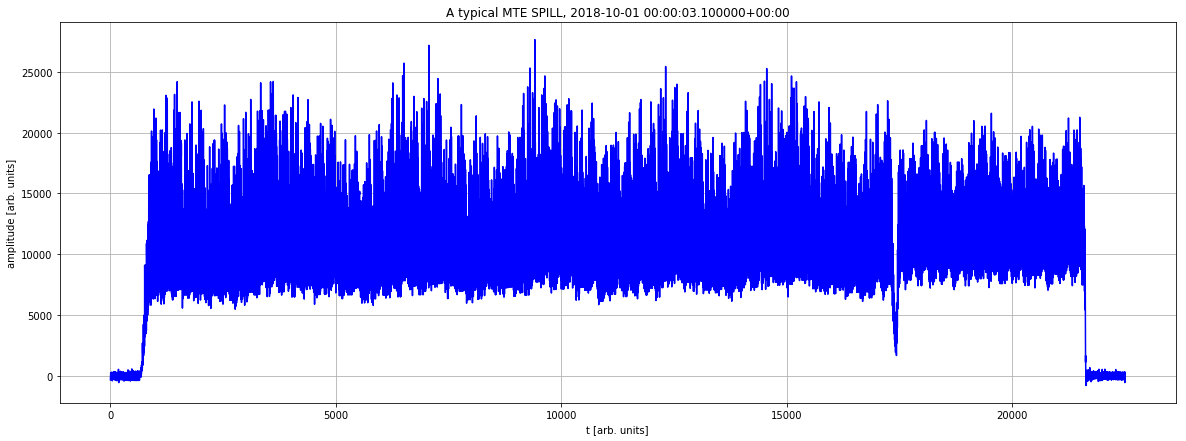

In [13]:
t1=pd.Timestamp('2018-10-01', tz='UTC')
t2=pd.Timestamp('2018-10-01 00:01', tz='UTC')
df=importNXCALS(['CPS.TGM:USER','PR.SCOPE48.CH01:MTE_SPILL'], t1,t2)
df=df.filter(df.CPS__TGM___USER=='SFTPRO1')

plt.figure(figsize=(20,7))
my_row=df.take(2)[0] # it is not sorted!
plt.plot(my_row['PR__SCOPE48__CH01___MTE_SPILL'],'b')
plt.title(f'A typical MTE SPILL, {pd.Timestamp(my_row["timestamp"]).tz_localize("UTC")}') # it is a heavy signal (>20k samples)
plt.xlabel('t [arb. units]') # it is a heavy signal (>20k samples)
plt.ylabel('amplitude [arb. units]') # it is a heavy signal (>20k samples)
plt.grid(True)

Here we just consider a short interval (1 second) to prepare the UDF.

In [14]:
t1=pd.Timestamp('2018-10-01', tz='UTC')
t2=pd.Timestamp('2018-10-01 00:01', tz='UTC')
df=importNXCALS(['CPS.TGM:USER','CPS.LSA:CYCLE','PR.SCOPE48.CH01:MTE_SPILL', 'PR.SCOPE48.CH01:MTE_EFFICIENCY'], t1,t2)
df=df.filter(df.CPS__TGM___USER=='SFTPRO1')
df.limit(5).show()

+-------------------+---------------+----------------+-----------------------------+----------------------------------+
|          timestamp|CPS__TGM___USER|CPS__LSA___CYCLE|PR__SCOPE48__CH01___MTE_SPILL|PR__SCOPE48__CH01___MTE_EFFICIENCY|
+-------------------+---------------+----------------+-----------------------------+----------------------------------+
|1538352003100000000|        SFTPRO1|       MTE_2018_|         [-348.93102797674...|                      0.1991091949|
|1538352047500000000|        SFTPRO1|       MTE_2018_|         [-124.17984259390...|                      0.1969342292|
|1538352031900000000|        SFTPRO1|       MTE_2018_|         [-127.18853975281...|                      0.1994075732|
|1538352046300000000|        SFTPRO1|       MTE_2018_|         [160.132474568082...|                      0.1974465434|
|1538352004300000000|        SFTPRO1|       MTE_2018_|         [241.22672082312,...|                      0.1988264771|
+-------------------+---------------+---

And here the UDF to compute the Multi-Turn-Extraction efficiency.

In [15]:
def MTE_efficiency(myNewSpill):
    b1_idx=2066-1500
    b2_idx=6267-1500
    b3_idx=10468-1500
    b4_idx=14669-1500
    b5_idx=18871-1500
    b6_idx=23072-1500
    is1=np.mean(myNewSpill[b1_idx:b2_idx])
    is2=np.mean(myNewSpill[b2_idx:b3_idx])
    is3=np.mean(myNewSpill[b3_idx:b4_idx])
    is4=np.mean(myNewSpill[b4_idx:b5_idx])
    core=np.mean(myNewSpill[b5_idx:b6_idx])
    mySum=(is1+is2+is3+is4+core);
    MTE_efficiency=np.mean([is1,is2,is3,is4])/mySum;
    return np.float(MTE_efficiency)

my_udf = func.udf(MTE_efficiency, DoubleType())


new_df=df.withColumn('recomputed_MTE_efficiency',my_udf(col('PR__SCOPE48__CH01___MTE_SPILL')))

new_df=new_df.select(['timestamp','PR__SCOPE48__CH01___MTE_EFFICIENCY','recomputed_MTE_efficiency'])

_to_pandas(new_df).head()

PR.SCOPE48.CH01:MTE_EFFICIENCY  \
2018-10-01 00:00:03.100000+00:00                        0.199109   
2018-10-01 00:00:04.300000+00:00                        0.198826   
2018-10-01 00:00:17.500000+00:00                        0.198757   
2018-10-01 00:00:18.700000+00:00                        0.201958   
2018-10-01 00:00:31.900000+00:00                        0.199408   

                                  recomputed_MTE_efficiency  
2018-10-01 00:00:03.100000+00:00                   0.199109  
2018-10-01 00:00:04.300000+00:00                   0.198826  
2018-10-01 00:00:17.500000+00:00                   0.198757  
2018-10-01 00:00:18.700000+00:00                   0.201958  
2018-10-01 00:00:31.900000+00:00                   0.199408

We can also make more complex operation. In the following we are doing an FFT and we take the amplitude of an arbitrary frequency (index 500 of the FFT vector). NB: we cast the return value conveniently.

In [16]:
def MTE_FFT(myNewSpill):
    aux=np.abs(np.fft.fft(myNewSpill))[500]
    return np.float(aux)

my_udf = func.udf(MTE_FFT, DoubleType())

new_df=df.withColumn('MTE_fft',my_udf(col('PR__SCOPE48__CH01___MTE_SPILL')))
new_df=new_df.select(['timestamp','MTE_fft'])
_to_pandas(new_df).head()

MTE_fft
2018-10-01 00:00:03.100000+00:00  197133.558863
2018-10-01 00:00:04.300000+00:00  146918.300598
2018-10-01 00:00:17.500000+00:00  187465.831250
2018-10-01 00:00:18.700000+00:00  272500.715750
2018-10-01 00:00:31.900000+00:00  161438.769078

### A good balance: pyspark and pandas

Here we make a simple example of big data analysis where one can find a reasonable trade-off between **pyspark** and **pandas**. We will analyze one full year in one-go (by far out of the CALS reach).

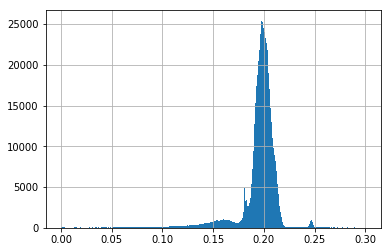

In [53]:
t1=pd.Timestamp('2018', tz='UTC')
t2=pd.Timestamp('2019', tz='UTC')
df=importNXCALS(['PR.SCOPE48.CH01:MTE_SPILL'], t1,t2)

#### 

def MTE_efficiency(myNewSpill):
    b1_idx=2066-1500
    b2_idx=6267-1500
    b3_idx=10468-1500
    b4_idx=14669-1500
    b5_idx=18871-1500
    b6_idx=23072-1500
    is1=np.mean(myNewSpill[b1_idx:b2_idx])
    is2=np.mean(myNewSpill[b2_idx:b3_idx])
    is3=np.mean(myNewSpill[b3_idx:b4_idx])
    is4=np.mean(myNewSpill[b4_idx:b5_idx])
    core=np.mean(myNewSpill[b5_idx:b6_idx])
    mySum=(is1+is2+is3+is4+core);
    MTE_efficiency=np.mean([is1,is2,is3,is4])/mySum;
    return np.float(MTE_efficiency)

my_udf = func.udf(MTE_efficiency, DoubleType())

new_df=df.withColumn('recomputed_MTE_efficiency',my_udf(col('PR__SCOPE48__CH01___MTE_SPILL')))

new_df=new_df.select(['timestamp','recomputed_MTE_efficiency'])
pdf=_to_pandas(new_df)

aux=pdf[(pdf['recomputed_MTE_efficiency']>0) & (pdf['recomputed_MTE_efficiency']<0.3)]
plt.hist(aux['recomputed_MTE_efficiency'].values,1000);
plt.grid()

In [58]:
len(pdf)

1815048

!!! success
    There were more than 1.8M of arrays (each arrays containing more that 20k of elements) processed in ~5 min.
    
### Conclusions

We would like to thanks all the NXCALS for they support and help. We think that the framework they designed has great potential for the big data analysis. 

**pytimber** still is fundamental for the typical use. It is not using, at least at the moment, the SPARK leverage but it is offering a simple to use interface.

!!! question
    Should we consider a better integration between **pytimber** and **pandas**?

We investigated the **pyspark** approach for big data analysis.
We  touched only the surface. Optimizing **pyspark** queries needs time and expertise, it is quite a long journey: here we showed how to make just the first steps.  

!!! info
    Depending on the community input, we can make a small wrapper of the function we used. We wanted to expose the rationale before wrapping the code, to get the feedback.